In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import skimage


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/Exp_Texture"

In [ ]:
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
def i2a(x):
  print(x)
  return 

In [ ]:
a = sorted(os.listdir(PATH+"/normals"))
b = sorted(os.listdir(PATH+"/tex"))

for i,j in zip(a,b):
  # print()
  if not i.split('_pxr128')[0]==j.split('_pxr128')[0]:
    print(i,j)

In [ ]:
normals = []
texs = []

nfs=[]
tfs=[]

for i in sorted(os.listdir(PATH+"/normals")):
  # nfs.append(i)    
  img_o = keras.preprocessing.image.load_img(PATH+"/normals/"+i)
  # img_o = skimage.imread(PATH+"/normals/"+i)
  img = keras.preprocessing.image.img_to_array(img_o)
  normals.append(img)
  nfs.append(i)

for i in sorted(os.listdir(PATH+"/tex")):
  # tfs.append(i)
  img_o = keras.preprocessing.image.load_img(PATH+"/tex/"+i)
  img = keras.preprocessing.image.img_to_array(img_o)
  texs.append(img)
  tfs.append(i)

# normals = np.array(normals)
# texs = np.array(texs)

In [ ]:
# Define the standard image size.
orig_img_size = (512, 512)
# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
    use_transpose=False,
):
    if use_transpose:
      x =  layers.Conv2DTranspose(
          filters,
          kernel_size,
          strides=strides,
          padding=padding,
          kernel_initializer=kernel_initializer,
          use_bias=use_bias,
      )(x)
    else:
      x = layers.UpSampling2D(
          size=(2,2) 
      )(x)
      x =  layers.Conv2D(
          filters,
          kernel_size,
          strides=1,
          padding=padding,
          kernel_initializer=kernel_initializer,
          use_bias=use_bias,
      )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [ ]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    # img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    # img = tf.image.resize(img, [*orig_img_size])
    # img = tf.image.resize(img, (input_img_size[0],input_img_size[1]),method="nearest")
    img = tf.image.central_crop(img,input_img_size[0]/512.0)
    # Random crop to 256X256
    # img = tf.image.crop_and_resize(img, crop_size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


def preprocess_test_image(img):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [ ]:
train_x = np.array(list(map(preprocess_train_image,texs)))
train_y = np.array(list(map(preprocess_train_image,normals)))

In [ ]:
# np.min(train_x),np.max(train_x),np.min(train_y),np.max(train_y)
np.min(texs),np.max(texs),np.min(normals),np.max(normals)

(0.0, 255.0, 0.0, 255.0)

In [ ]:
train_x.shape,train_y.shape

((129, 128, 128, 3), (129, 128, 128, 3))

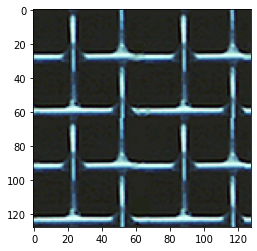

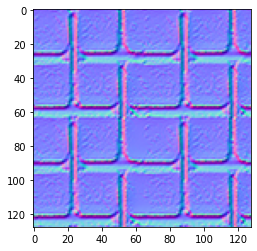

In [ ]:
ti = 126
plt.imshow((train_x[ti]*127.5+127.5)/255)
# plt.imshow((texs[ti])/255)
plt.show()
plt.imshow((train_y[ti]*127.5+127.5)/255)
# plt.imshow((normals[ti])/255)
plt.show()

In [ ]:
train_x[ti].shape

(128, 128, 3)

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=1,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


In [ ]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [ ]:
# gen_G.summary()
# gen_F.summary()

In [ ]:
# disc_X.summary()
# disc_Y.summary()

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=5):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        fig, ax = plt.subplots(self.num_img, 3, figsize=(12, 12))
        ri = random.sample(range(0, len(train_x)), self.num_img)
        imgs = train_x[ri]
        tnorm = train_y[ri]
        prediction = self.model.gen_G(imgs).numpy()
        prediction = prediction
        for i in range(len(imgs)):
          img = imgs[i]
          # print(np.min(prediction[i]),np.max(prediction[i]))
          ax[i,0].imshow((img*127.5+127.5)/255.0)
          ax[i,1].imshow((prediction[i]*127.5+127.5)/255.0)
          ax[i,2].imshow((tnorm[i]*127.5+127.5)/255.0)
          ax[i,0].set_title("Input image:"+str(ri[i])+"-"+tfs[ri[i]],color="r")
          ax[i,1].set_title("Translated image")
          ax[i,2].set_title("True image")
          ax[i,0].axis("off")
          ax[i,1].axis("off")
          ax[i,2].axis("off")

        # prediction = keras.preprocessing.image.array_to_img(prediction)
        fig.savefig(
            PATH+"/out/generated_{epoch}.png".format(epoch=str(epoch+1).zfill(4))
        )
        fig.savefig(
            "out/generated_{epoch}.png".format(epoch=str(epoch+1).zfill(4))
        )
        # plt.show()
        plt.close()

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)
# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)


In [ ]:
!mkdir ./out
!rm -f "/content/drive/MyDrive/Colab Notebooks/Exp_Texture/out/*"
!rm -f out/*
# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
with strategy.scope():
  hist = cycle_gan_model.fit(
      train_x,train_y,
      epochs=20,
      callbacks=plotter,
  )

mkdir: cannot create directory ‘./out’: File exists
Epoch 1/20
5/5 [==============================] - 6s 1s/step - G_loss: 4.0358 - F_loss: 6.0097 - D_X_loss: 0.0687 - D_Y_loss: 0.2681
Epoch 2/20
5/5 [==============================] - 6s 1s/step - G_loss: 2.8895 - F_loss: 5.7324 - D_X_loss: 0.0620 - D_Y_loss: 0.1542
Epoch 3/20
5/5 [==============================] - 6s 1s/step - G_loss: 2.5661 - F_loss: 5.3240 - D_X_loss: 0.0790 - D_Y_loss: 0.1958
Epoch 4/20
5/5 [==============================] - 6s 1s/step - G_loss: 3.4629 - F_loss: 5.5676 - D_X_loss: 0.0523 - D_Y_loss: 0.1612
Epoch 5/20
5/5 [==============================] - 6s 1s/step - G_loss: 3.5742 - F_loss: 5.8440 - D_X_loss: 0.0477 - D_Y_loss: 0.1250
Epoch 6/20
5/5 [==============================] - 6s 1s/step - G_loss: 2.7061 - F_loss: 5.8374 - D_X_loss: 0.0561 - D_Y_loss: 0.1823
Epoch 7/20
5/5 [==============================] - 6s 1s/step - G_loss: 2.9103 - F_loss: 5.9006 - D_X_loss: 0.0420 - D_Y_loss: 0.1052
Epoch 8/20
5/5 [=

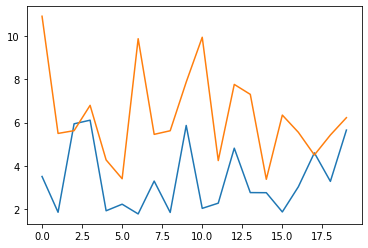

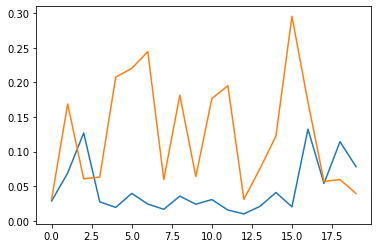

In [ ]:
D_X_loss = hist.history['D_X_loss']
D_Y_loss = hist.history['D_Y_loss']
G_loss = hist.history['G_loss']
F_loss = hist.history['F_loss']

plt.plot(G_loss)
plt.plot(F_loss)
plt.show()
plt.plot(D_X_loss)
plt.plot(D_Y_loss)
plt.show()

In [ ]:
#test image
t_o = keras.preprocessing.image.load_img('Wood_floor.png')
timg = keras.preprocessing.image.img_to_array(t_o)
# timg_rs = tf.image.resize(timg,[128,128],method='nearest').numpy()

Red-orange_glazed_pxr128.tif


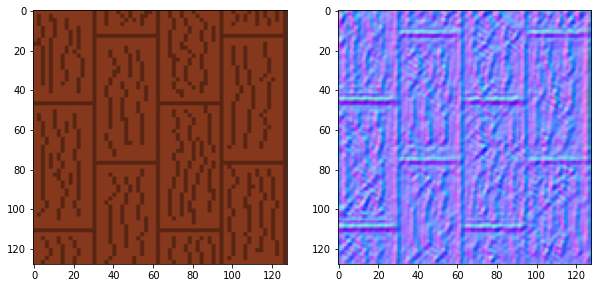

In [ ]:
from IPython.core.pylabtools import figsize
ri = int(random.random()*len(train_x))
ri=87
print(tfs[ri])
# test = (train_x[ri]*127.5+127.5)/255
test = timg_rs/255
# p = cycle_gan_model.gen_G(train_x[ri].reshape(1,train_x.shape[1],train_x.shape[2],train_x.shape[3])).numpy()
p = cycle_gan_model.gen_G(timg_rs.reshape(1,train_x.shape[1],train_x.shape[2],train_x.shape[3])).numpy()
res = (p[0]*127.5+127.5)/255
_,ax = plt.subplots(1,2,figsize=(10,20))
ax[0].imshow(test)
ax[1].imshow(res)
plt.show()

In [ ]:
import matplotlib

matplotlib.image.imsave("/content/drive/MyDrive/Colab Notebooks/Exp_Texture/t.png", test)
matplotlib.image.imsave("t.png", test)
matplotlib.image.imsave("/content/drive/MyDrive/Colab Notebooks/Exp_Texture/r.png", res)
matplotlib.image.imsave("r.png", res)